### Importing necessary libraries 

In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [3]:
print("Number of train images: " , len(os.listdir('./train')) )
print("Number of test images: "  , len(os.listdir('./test')) )

Number of train images:  8250
Number of test images:  969


In [4]:
no_of_inverted = len([files for files in os.listdir('./train') if 'inverted' in files])
no_of_normal = len([files for files in os.listdir('./train') if 'normal' in files])
print("Inverted images in train dataset: ",  no_of_inverted)
print("Normal images in train dataset: ", no_of_normal)
if no_of_inverted==no_of_normal:
    total_images = no_of_inverted
    print('Balanced dataset')
else:
    total_images = no_of_normal

Inverted images in train dataset:  4125
Normal images in train dataset:  4125
Balanced dataset


In [5]:
base_dir = 'data/'
dirs = ['train','val','test']
sub_dirs = ['inverted','normal']
for dir in dirs:
    dir =  os.path.join(base_dir, dir)
    os.makedirs(dir,exist_ok=True)
    for sub_dir in sub_dirs:
        sub_dir = os.path.join(dir, sub_dir)
        os.makedirs(sub_dir,exist_ok=True)

In [6]:
split = {'train': 0.7,
         'val': 0.3}

for dir in dirs[:2]:
    print(int(split[dir]*total_images))

2887
1237


In [7]:
split_size = 0.7

split = {'train': (0,int(split_size*total_images)),
         'val': (int(split_size*total_images),total_images)}

for obj in sub_dirs:
    for dir in dirs[:2]:
        #print(obj[:])
        files = ['{}_{}.jpg'.format(obj[:],i) for i in range(*split[dir])]
        #print(files)
        for filename in files:
            src = os.path.join('./train', filename)
            dst = os.path.join(base_dir,dir,obj,filename)
            shutil.copyfile(src,dst)
print("Train validation split completed.")

Train validation split completed.


In [8]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training pictures
train_inverted_dir = os.path.join(train_dir, 'inverted')
train_normal_dir = os.path.join(train_dir, 'normal')

# Directory with our validation pictures
validation_inverted_dir = os.path.join(validation_dir, 'inverted')
validation_normal_dir = os.path.join(validation_dir, 'normal')

In [9]:
train_inverted_fnames = os.listdir( train_inverted_dir )
train_normal_fnames = os.listdir( train_normal_dir )

print(train_inverted_fnames[:10])
print(train_normal_fnames[:10])

['inverted_0.jpg', 'inverted_1.jpg', 'inverted_10.jpg', 'inverted_100.jpg', 'inverted_1000.jpg', 'inverted_1001.jpg', 'inverted_1002.jpg', 'inverted_1003.jpg', 'inverted_1004.jpg', 'inverted_1005.jpg']
['normal_0.jpg', 'normal_1.jpg', 'normal_10.jpg', 'normal_100.jpg', 'normal_1000.jpg', 'normal_1001.jpg', 'normal_1002.jpg', 'normal_1003.jpg', 'normal_1004.jpg', 'normal_1005.jpg']


In [10]:
print('total training inverted images :', len(os.listdir(train_inverted_dir)))
print('total training normal images :', len(os.listdir(train_normal_dir)))

print('total validation inverted images :', len(os.listdir(validation_inverted_dir)))
print('total validation normal images :', len(os.listdir(validation_inverted_dir)))

total training inverted images : 2887
total training normal images : 2887
total validation inverted images : 1238
total validation normal images : 1238


In [12]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
nrows = 4
ncols = 4
pic_index = 0

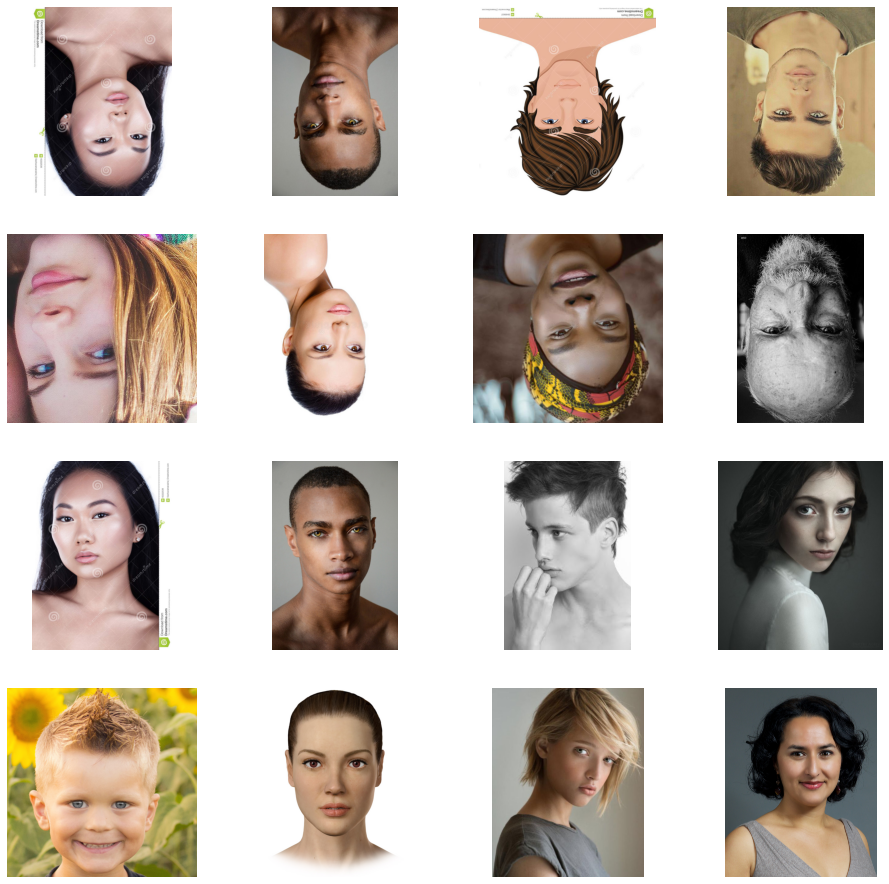

In [13]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8
next_inv_pix = [os.path.join(train_inverted_dir, fname) 
                for fname in train_inverted_fnames[ pic_index-8:pic_index] 
               ]
next_nor_pix = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]
for i, img_path in enumerate(next_inv_pix+next_nor_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [14]:
model = tf.keras.models.Sequential([
        Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)),
        Conv2D(64,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(4,4),

        Conv2D(128,kernel_size=(3,3),activation='relu'),    
        Conv2D(64,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(4,4),
    
        Flatten(),    
        Dense(512,activation='relu') ,
        Dropout(rate=0.3),
        Dense(1, activation='sigmoid'),    
        ])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      73792     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [16]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [17]:
datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=20,
                                              class_mode ='binary',
                                              target_size=(150,150))
validation_generator = datagen.flow_from_directory(validation_dir,
                                                   batch_size=20,
                                                   class_mode='binary',
                                                   target_size = (150,150))

Found 5774 images belonging to 2 classes.
Found 2476 images belonging to 2 classes.


(20, 150, 150, 3)
0.0


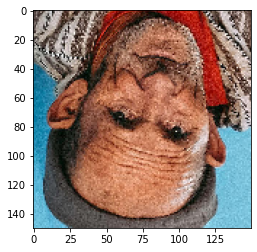

(20, 150, 150, 3)
1.0


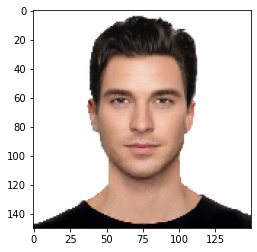

(20, 150, 150, 3)
0.0


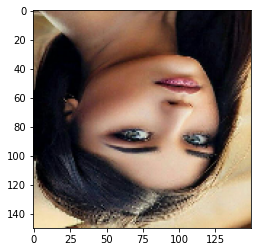

(20, 150, 150, 3)
0.0


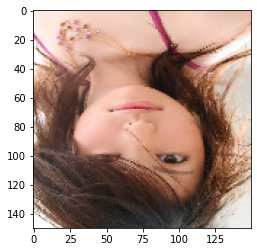

(20, 150, 150, 3)
0.0


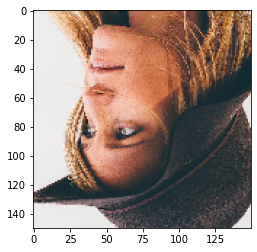

In [18]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [19]:
histroy = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_steps = 50,
                    verbose=1)

Epoch 1/50
100/100 [==============================] - 309s 3s/step - loss: 0.6562 - accuracy: 0.6360 - val_loss: 0.4074 - val_accuracy: 0.8260
Epoch 2/50
100/100 [==============================] - 164s 2s/step - loss: 0.3170 - accuracy: 0.8852 - val_loss: 0.4254 - val_accuracy: 0.8820
Epoch 3/50
100/100 [==============================] - 142s 1s/step - loss: 0.1972 - accuracy: 0.9245 - val_loss: 0.1361 - val_accuracy: 0.9530
Epoch 4/50
100/100 [==============================] - 135s 1s/step - loss: 0.1613 - accuracy: 0.9403 - val_loss: 0.3011 - val_accuracy: 0.8920
Epoch 5/50
100/100 [==============================] - 128s 1s/step - loss: 0.1323 - accuracy: 0.9540 - val_loss: 0.4876 - val_accuracy: 0.8310
Epoch 6/50
100/100 [==============================] - 129s 1s/step - loss: 0.1034 - accuracy: 0.9670 - val_loss: 0.0702 - val_accuracy: 0.9820
Epoch 7/50
100/100 [==============================] - 128s 1s/step - loss: 0.1040 - accuracy: 0.9655 - val_loss: 0.0766 - val_accuracy: 0.9770

In [28]:
# save weights
model.save('invertedImages.h5')

In [ ]:
acc      = model.history.history[     'accuracy' ]
val_acc  = model.history.history[ 'val_accuracy' ]
loss     = model.history.history[    'loss' ]
val_loss = model.history.history['val_loss' ]

epochs   = range(len(acc)) 

# Accuracy per epoch
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

# Loss Per Epoch
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [29]:
saved_model = tf.keras.models.load_model('invertedImages.h5')

Model testing on test data

In [33]:
predictions = []
for filename in ['{}.jpg'.format(i) for i in range(0,len(os.listdir('test')))]:
    img = load_img(os.path.join('test',filename), target_size=(150, 150))
    x = img_to_array(img)                         
    x = x.reshape((1,) + x.shape)                 
    x /= 255.0
    y_hat= model.predict(x)
    predictions.append(y_hat)

array([[0.9999999]], dtype=float32)

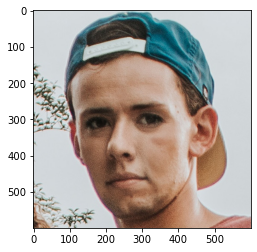

In [118]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('./test/709.jpg', 'r')
imshow(np.asarray(pil_im))
predictions[599]

In [51]:
print(predictions[709][0])

[1.]


In [65]:
test_y=[1 for i in range(969)] 
for i in range(510):
    test_y[i] = 0

In [148]:
predictions
y_pred = [1 for i in range(969)]
for i in range(969):
    if predictions[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

y_true = [1 for i in range(969)]
for i in range(510):
    y_true[i] = 0

In [149]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.9834881320949432

### Test images to check if they are inverted: 

In [126]:
from ipywidgets import FileUpload
from IPython.display import display
upload = FileUpload(accept='.jpg', multiple=True)
display(upload)

FileUpload(value={}, accept='.jpg', description='Upload', multiple=True)

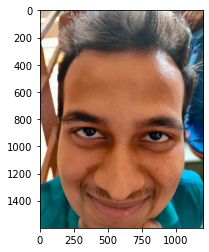

In [127]:
import io
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
for name, file_info in upload.value.items():
    img = Image.open(io.BytesIO(file_info['content']))
imshow(np.asarray(img))

In [131]:
img = img.resize((150,150))
x = img_to_array(img)                         
x = x.reshape((1,) + x.shape)                 
x /= 255.0
classes = model.predict(x)
if classes[0]>0:
    print("Uploaded image is Not Inverted")
else:
    print("Uploaded image is Inverted")

Uploaded image is Not Inverted
